In [16]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import time
from scipy.stats import expon

In [17]:
resources_path = "../resources"
res_path = "../res/"

In [18]:
print("Number of packets in images.csv - {}".format(pd.read_csv(resources_path + "/images.csv").shape[0]))
print("Number of packets in videos.csv - {}".format(pd.read_csv(resources_path +  "/videos.csv").shape[0]))
print("Number of packets in audio.csv - {}".format(pd.read_csv(resources_path +  "/audio.csv").shape[0]))
print("Number of packets in spotify.csv - {}".format(pd.read_csv(resources_path +  "/spotify.csv").shape[0]))

Number of packets in images.csv - 1297
Number of packets in videos.csv - 1344
Number of packets in audio.csv - 1189
Number of packets in spotify.csv - 2381


# Functions

In [19]:
def plot_message_sizes(filename: str):
    # read csv file
    df = pd.read_csv(filename)

    # filter only incoming packets
    df = df.loc[df['Destination'] == '10.0.2.15']

    # filter only relevant columns
    df = df[['Time', 'Length']]

    # Find the maximum packet length for normalization
    max_length = df['Length'].max()

    # Normalize the packet lengths
    df['Normalized Length'] = df['Length'] / max_length

    counts, bin_edges = np.histogram(df['Normalized Length'], bins=1000, density=True)
    ccdf = 1 - np.cumsum(counts) / np.sum(counts)

    plt.plot(bin_edges[1:], ccdf, label=filename.split('/')[2].split('.')[0])
    plt.xlabel("Normalized Packet Length to their maximum value")
    plt.ylabel("CCDF")

    plt.grid(which='both', linestyle='-', linewidth=0.5)
    #plt.legend()

In [20]:
def plot_inter_message_delay(filename: str, ax: plt.Axes = None):  
    # read csv file
    df = pd.read_csv(filename)

    # filter only incoming packets
    df = df.loc[df['Destination'] == '10.0.2.15']

    # filter only relevant columns
    df = df[['Time', 'Length']]

    burst_data = [] 

    time = sorted(df['Time'].tolist())
    inter_message_delays = [float(time[i+1] - time[i]) for i in range(len(time)-1)]

    # plot probability desnsity function of inter-message delay for this burst, x-axis is time, y-axis is PDF
    num_bins = 'auto'  # Use 'auto' to calculate the number of bins based on data distribution
    hist, bin_edges = np.histogram(inter_message_delays, bins=num_bins, density=True)

    # # Normalize the histogram
    bin_width = bin_edges[1] - bin_edges[0]
    pdf = hist * bin_width

    # plot the PDF in step function
    ax.step(bin_edges[:-1], pdf, where='mid', label='Histogram of Inter-message Delay')
    ax.set_xlabel('Inter-message Delay (Seconds)')
    ax.set_ylabel('Probability Density Function (PDF)')
    ax.set_title("PDF of Inter-message Delay for " + filename.split('/')[2].split('.')[0])
    
    # fit the exponential distribution according to the data pdf and bin
    fit_params = expon.fit(inter_message_delays)
    fitted_pdf = expon.pdf(bin_edges[:-1], loc=fit_params[0], scale=fit_params[1])
    fitted_pdf = fitted_pdf * bin_width
    
    # Plot the fitted exponential distribution as a line
    ax.plot(bin_edges[:-1], fitted_pdf, label='Fitted Exponential', color='red')
    ax.grid(True)
    ax.legend()

In [21]:
def plot_traffic(filename: str, ax: plt.Axes = None):
   # read csv file
    df = pd.read_csv(filename)

    # filter only incoming packets
    df = df.loc[(df['Destination'] == '10.0.2.15') | (df['Destination'] == '2001:67c:4e8:f004::9')]

    # filter only relevant columns
    df = df[['Time', 'Length']]

    bin_range = (df['Length'].min(), df['Length'].max()) 
    time_interval = 0.01

    ax.hist(df.Time, weights=df.Length, bins=200)
    ax.set_xlabel("Time(Seconds)")
    ax.set_ylabel("Packet Length")
    ax.set_title("Traffic for " + filename.split("/")[-1].split(".")[0])

# Graphs

## Traffic

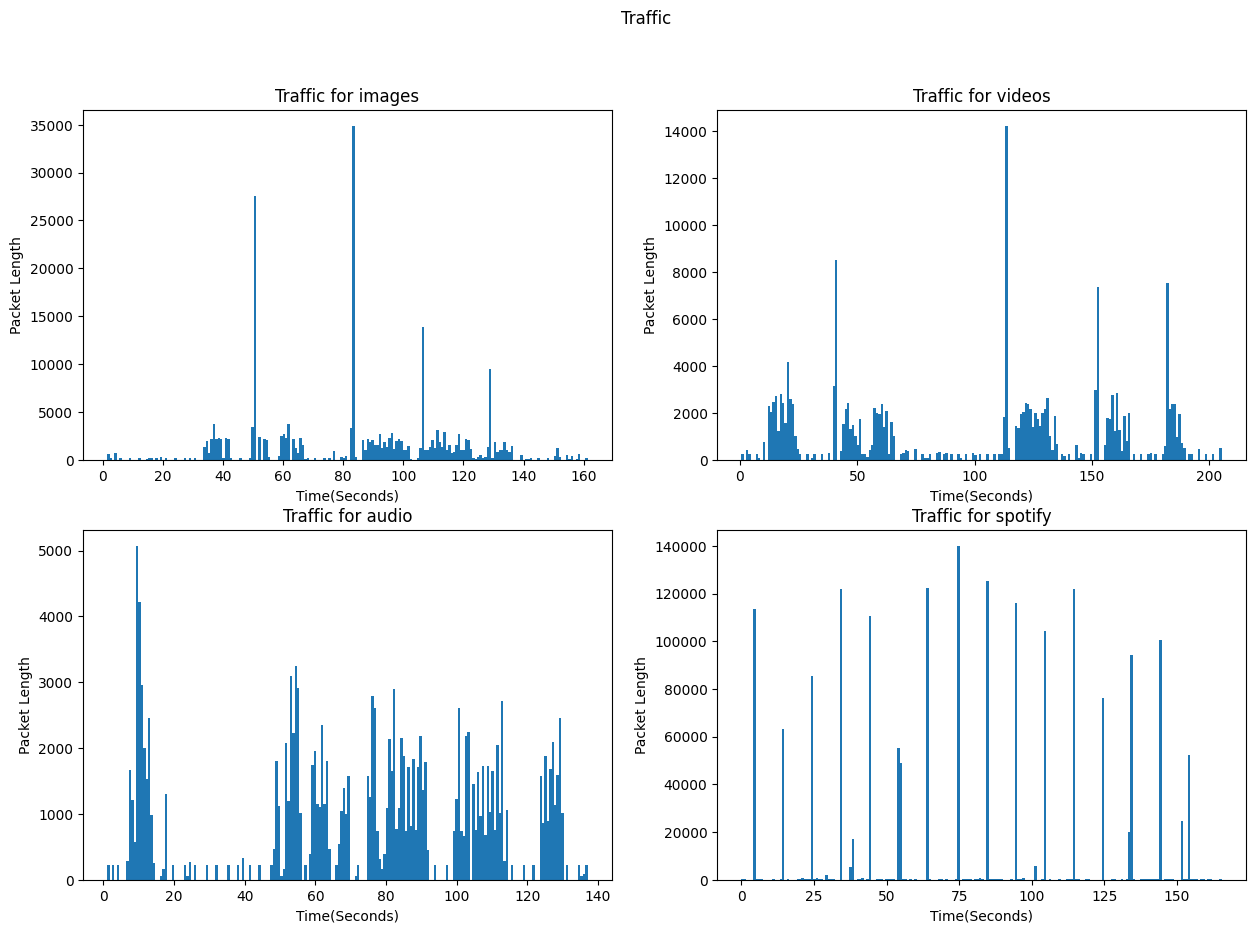

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Traffic')
plot_traffic(resources_path + "/images.csv", axs[0, 0])
plot_traffic(resources_path + "/videos.csv", axs[0, 1])
plot_traffic(resources_path + "/audio.csv", axs[1, 0])
plot_traffic(resources_path + "/spotify.csv", axs[1, 1])
plt.savefig(res_path + "traffic.png")

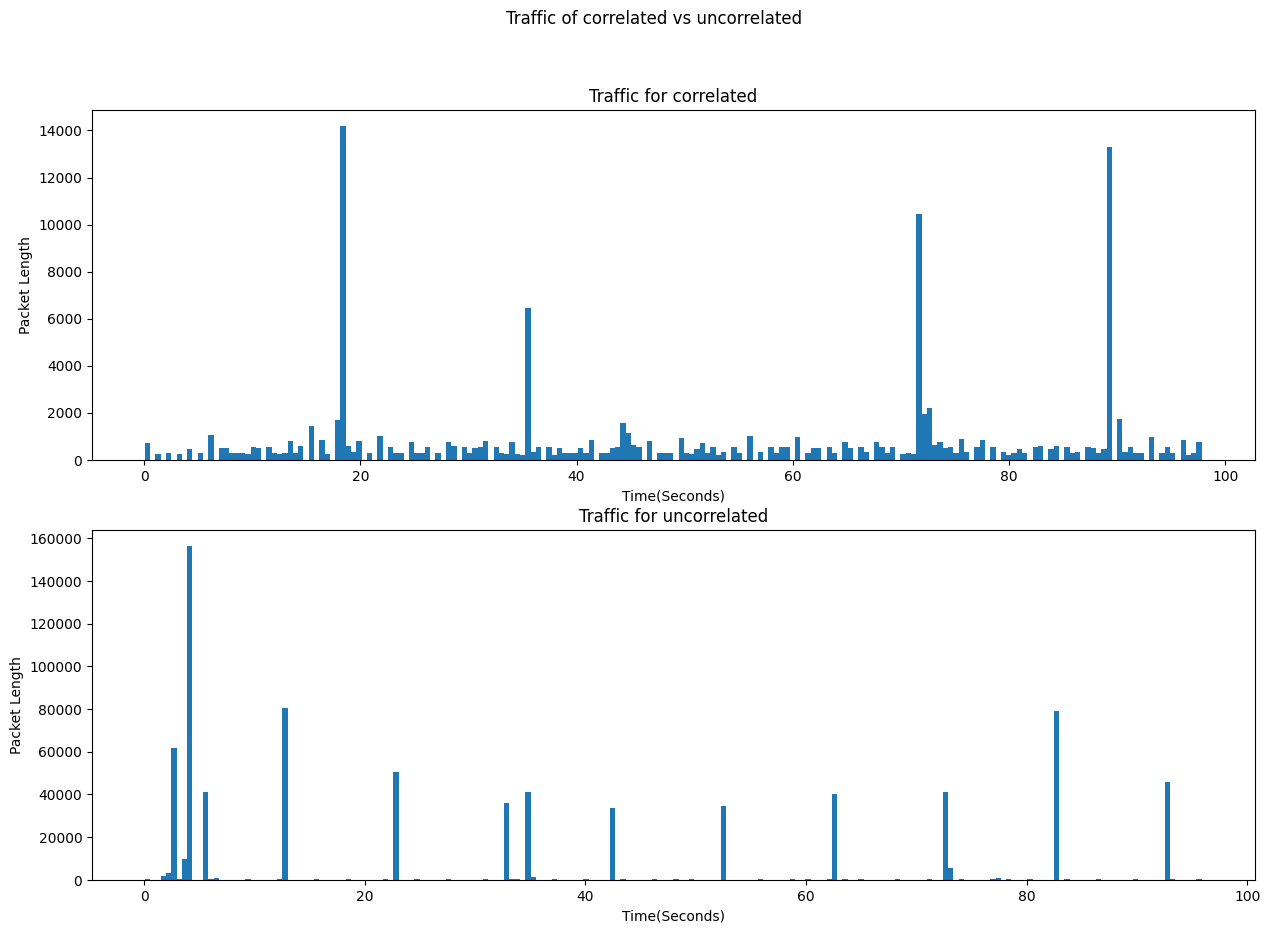

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Traffic of correlated vs uncorrelated')
plot_traffic(resources_path + "/correlated.csv", axs[0])
plot_traffic(resources_path + "/uncorrelated.csv", axs[1])
plt.savefig(res_path + "Traffic of correlated vs uncorrelated.png")

Conclusion: it is easy to infer from the graphs who belongs to a group assuming they are active in only 1 group.

## PDF 

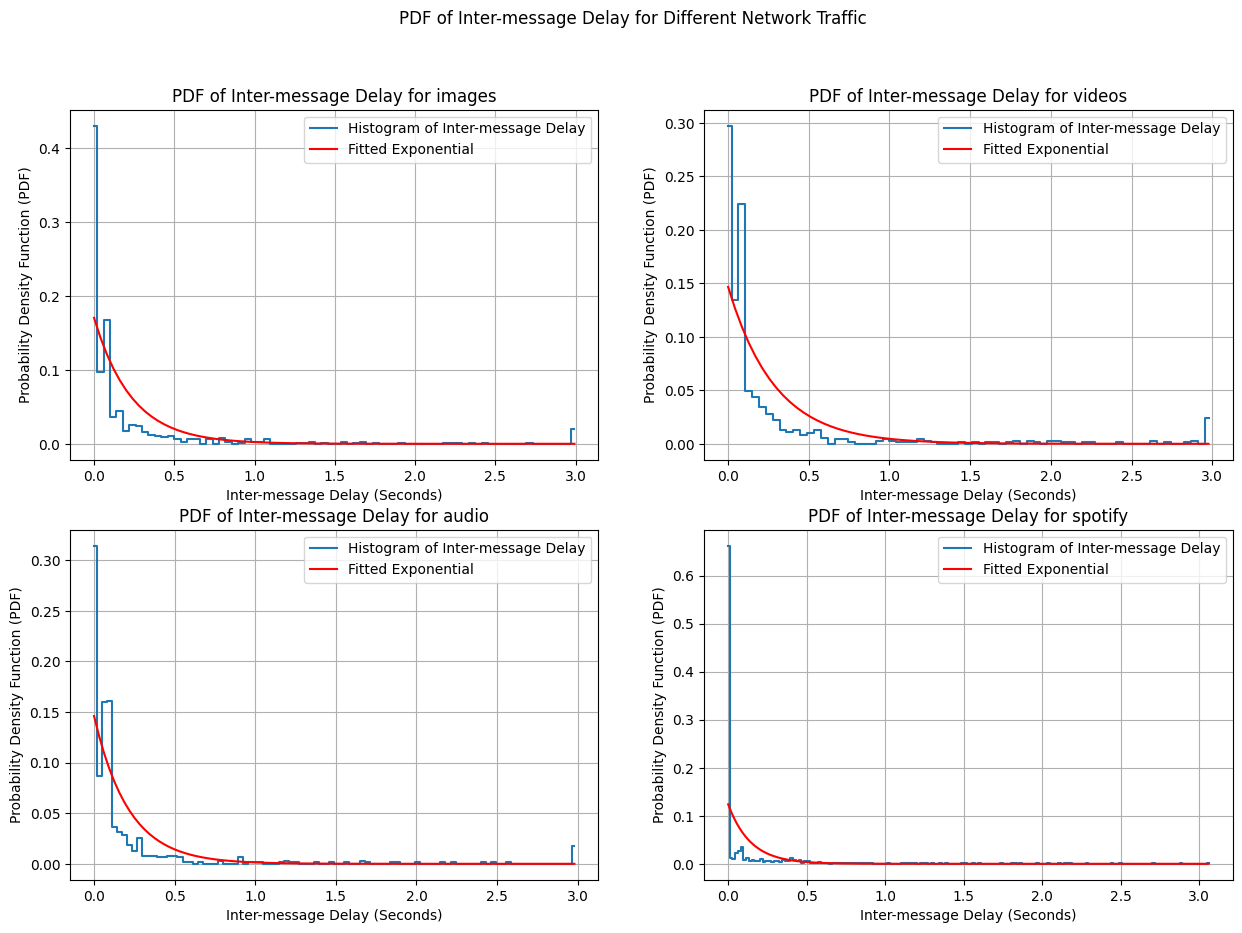

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('PDF of Inter-message Delay for Different Network Traffic')
plot_inter_message_delay(resources_path + "/images.csv", axs[0, 0])
plot_inter_message_delay(resources_path + "/videos.csv", axs[0, 1])
plot_inter_message_delay(resources_path + "/audio.csv", axs[1, 0])
plot_inter_message_delay(resources_path + "/spotify.csv", axs[1, 1])
plt.savefig(res_path + "PDF.png")

Conclusion: We can see that the delay is very low. So it won't impact the results of the research.

## CCDF

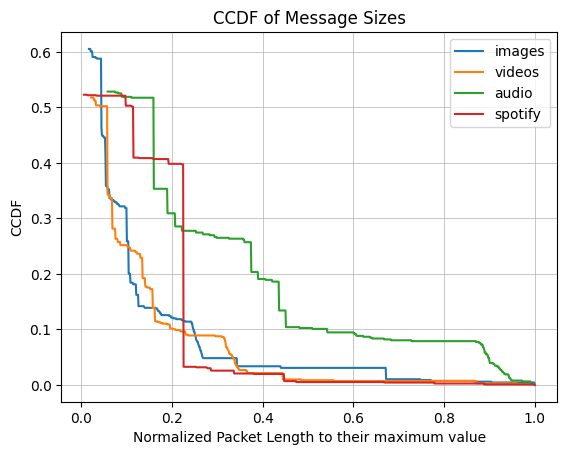

In [25]:
plot_message_sizes(resources_path + "/images.csv")
plot_message_sizes(resources_path + "/videos.csv")
plot_message_sizes(resources_path + "/audio.csv")
plot_message_sizes(resources_path + "/spotify.csv")
plt.title("CCDF of Message Sizes")
plt.legend()
plt.savefig(res_path + "CCDF.png")

Conclusion: We can see the spikes more clearly in "images" and "videos" than "audio".